# Projet numérique de science des données - COTILLARD Tristan et OUCHTAR Tasnime

## Introduction au projet

Il s'agit dans ce projet d'utiliser des données cartographiques décrivant des carrées de 30m x 30m pour construire un modèle prédictif de l'espèce d'arbre présente sur un tel carré.

Le but final est d'appliquer ce modèle pour faire des prédictions pour des données pour lesquelles vous ne disposez pas d'une étiquette.

__Consignes :__ 
* Vous devez rendre, par binôme :
    * un notebook jupyter
    * un fichier de prédictions (voir plus bas pour le format)
* __Renseignez vos noms/prénoms__ dans le titre du notebook
* Vous avez jusqu'au __1er juillet midi heure de Paris__
* Déposez vos fichiers [sur Campus](https://campus.mines-paristech.fr/course/view.php?id=404) dans la section dédiée (un seul rendu par binôme est nécessaire)


__Déroulé :__
* Les séances du lundi 14/06 (15h30-17h) et jeudi 24/06 (15h30-17h) sont dédiées au projet numérique. Faites-en bon usage.
* Certaines sections font appel à des notions qui n'auront pas encore été vues le 14/06 ; c'est indiqué le cas échéant.

## Données

### Données publiques et privées

Le dossier `data/` contient deux jeux de données :
* `data/foret_public.tsv` contient les données étiquetées, à partir desquelles construire votre modèle
* `data/foret_prive.tsv` contient les données non-étiquetées, pour lesquelles faire vos prédictions.

Chaque ligne dans les données correspond à un carré de 30 m x 30m, décrit par les variables suivantes :
* `altitude` : altitude en mètres
* `exposition` : azimut en degrés 
* `pente` : pente en degrés
* `distance_horizontale_hydro` : distance horizontale au point d'eau le plus proche (en mètres)
* `distance_verticale_hydro` : distance verticale au point d'eau le plus proche (en mètres)
* `distance_horizontale_route` : distance horizontale à la route la plus proche (en mètres)
* `ombrage_0900` : index d'ombrages à 9h du matin, au solstice, sur une échelle de 0 à 255
* `ombrage_1200` : index d'ombrages à midi, au solstice, sur une échelle de 0 à 255
* `ombrage_1500` : index d'ombrages à 15h, au solstice, sur une échelle de 0 à 255
* `distance_horizontale_depart_feu` : distance horizontale au départ de feu de forêt le plus proche (en mètres)
* `espece` : étiquette : espèce d'arbre présente (0 = pin tordu ; 1 = peuplier)|

### Chargement des données étiquetées

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd

In [3]:
df_public = pd.read_csv('data/foret_public.tsv', delimiter='\t')

In [4]:
df_public.head()

,altitude,exposition,pente,distance_horizontale_hydro,distance_verticale_hydro,distance_horizontale_route,ombrage_0900,ombrage_1200,ombrage_1500,distance_horizontale_depart_feu,espece
0,2804,139,9,268,65,3180,234,238,135,6121,0
1,2785,155,18,242,118,3090,238,238,122,6211,0
2,2579,132,6,300,-15,67,230,237,140,6031,0
3,2886,151,11,371,26,5253,234,240,136,4051,0
4,2742,134,22,150,69,3215,248,224,92,6091,0


### Extraction de la matrice de design et des étiquettes 

In [5]:
X_public = np.array(df_public.drop(columns=["espece"]))
y_public = np.array(df_public["espece"])

### Visualisation des variables

#### Question 1
Visualisez chacune des variables de `X_public` sous la forme de deux histogrammes superposés, l'un correspondant aux observations de la classe positive, l'autre correspondant aux observations de la classe négative.

__Conseils :__
* utilisez `pos_indices = np.where(y_public==1)[0]` pour déterminer les indices des lignes de `y_public` (et donc dans `X_public`) dont l'étiquette vaut 0.
* utilisez l'argument `alpha` de `plt.hist` pour rendre vos histogrammes transparents.

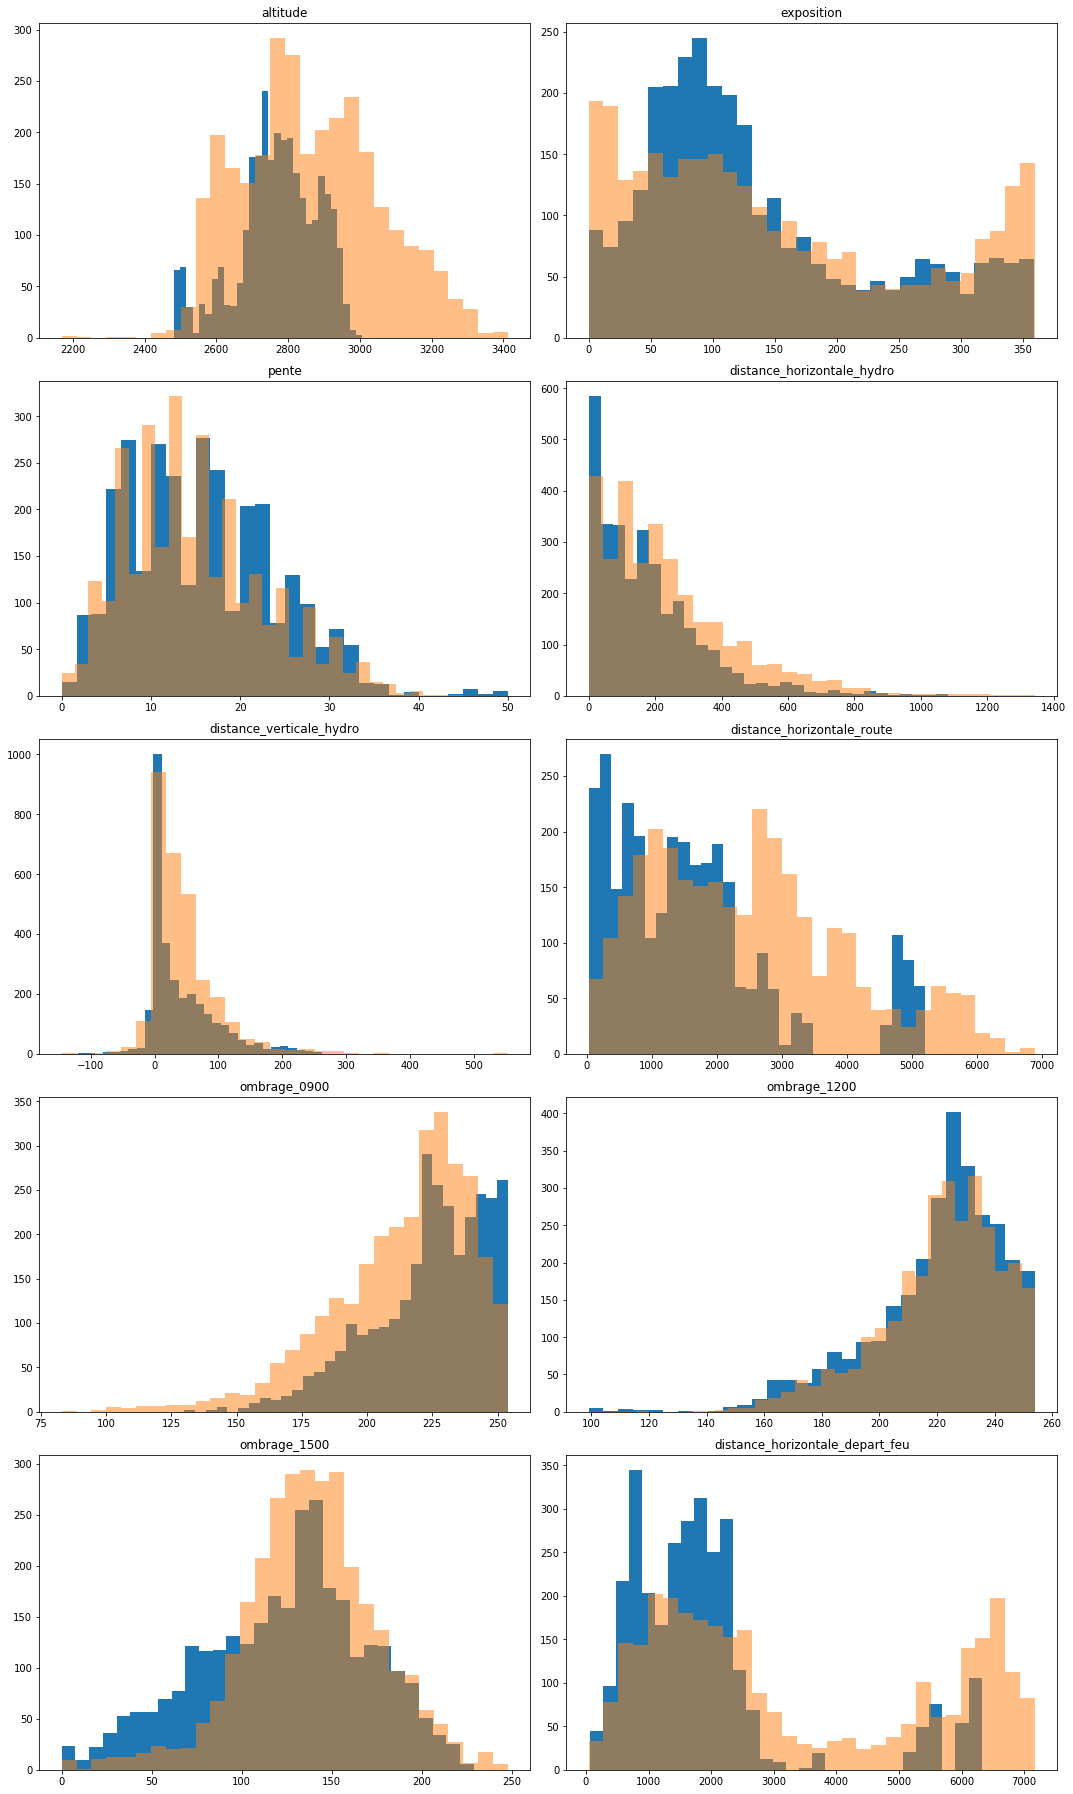

In [6]:
fig = plt.figure(figsize=(15, 25))
pos_indices = np.where(y_public == 1)[0]

neg_indices = np.where(y_public == 0)[0]

# Histograms
for (plot_idx, feat_idx) in enumerate(df_public.columns[:-1]):
    # create a subplot in the (plot_idx+1) position of a 2x5 grid
    ax = fig.add_subplot(5, 2, (plot_idx+1))
    # plot the histogram of feat_idx
    h_1 = ax.hist(X_public[pos_indices, plot_idx], bins=30, edgecolor='none')
    h_2 = ax.hist(X_public[neg_indices, plot_idx], bins=30, edgecolor='none', alpha=0.5)
    # use the name of the feature as a title for each histogram
    ax.set_title(feat_idx)
# espacement entre les subplots
fig.tight_layout(pad=1.0)

#### Question 2
Pensez-vous qu'il va être aisé de distinguer les deux classes ?

Quelques paramètres ont des tendances différentes, notamment l'altitude et la distance horizontale à la route qui peuvent permettre de faire la différence entre les deux espèces. Cependant les écarts ne sont pas assez flagrants pour permettre de distinguer clairement l'appartenance d'un arbre à une espèce. Il y a beaucoup de plages de valeurs communes aux deux espèces empêchant de se prononcer sur l'appartenance d'un arbre à l'une d'entre elles.

### Pré-traitement des variables

#### Question 3
Transformez vos variables d'une manière qui vous parait judicieuse, en vous appuyant notamment sur la PC 3. Vous pouvez essayer différents pré-traitements, mais ce n'est pas nécessaire. Justifiez vos choix. Utilisez un array numpy `X_public_preprocessed` pour enregistrer le résultat.

Deux algorithmes de preprocessing sont appliqués : StandardScaler et MinMaxScaler.  
Dans la suite du notebook, les premières parties du traitement (ou lorsque l'algorithme de preprocessing n'est pas précisé) concernent StandardScaler et les secondes MinMaxScaler. 

In [7]:
from sklearn import preprocessing

In [8]:
standard_scaler = preprocessing.StandardScaler()
standard_scaler.fit(X_public)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [9]:
X_public_preprocessed = standard_scaler.transform(X_public)

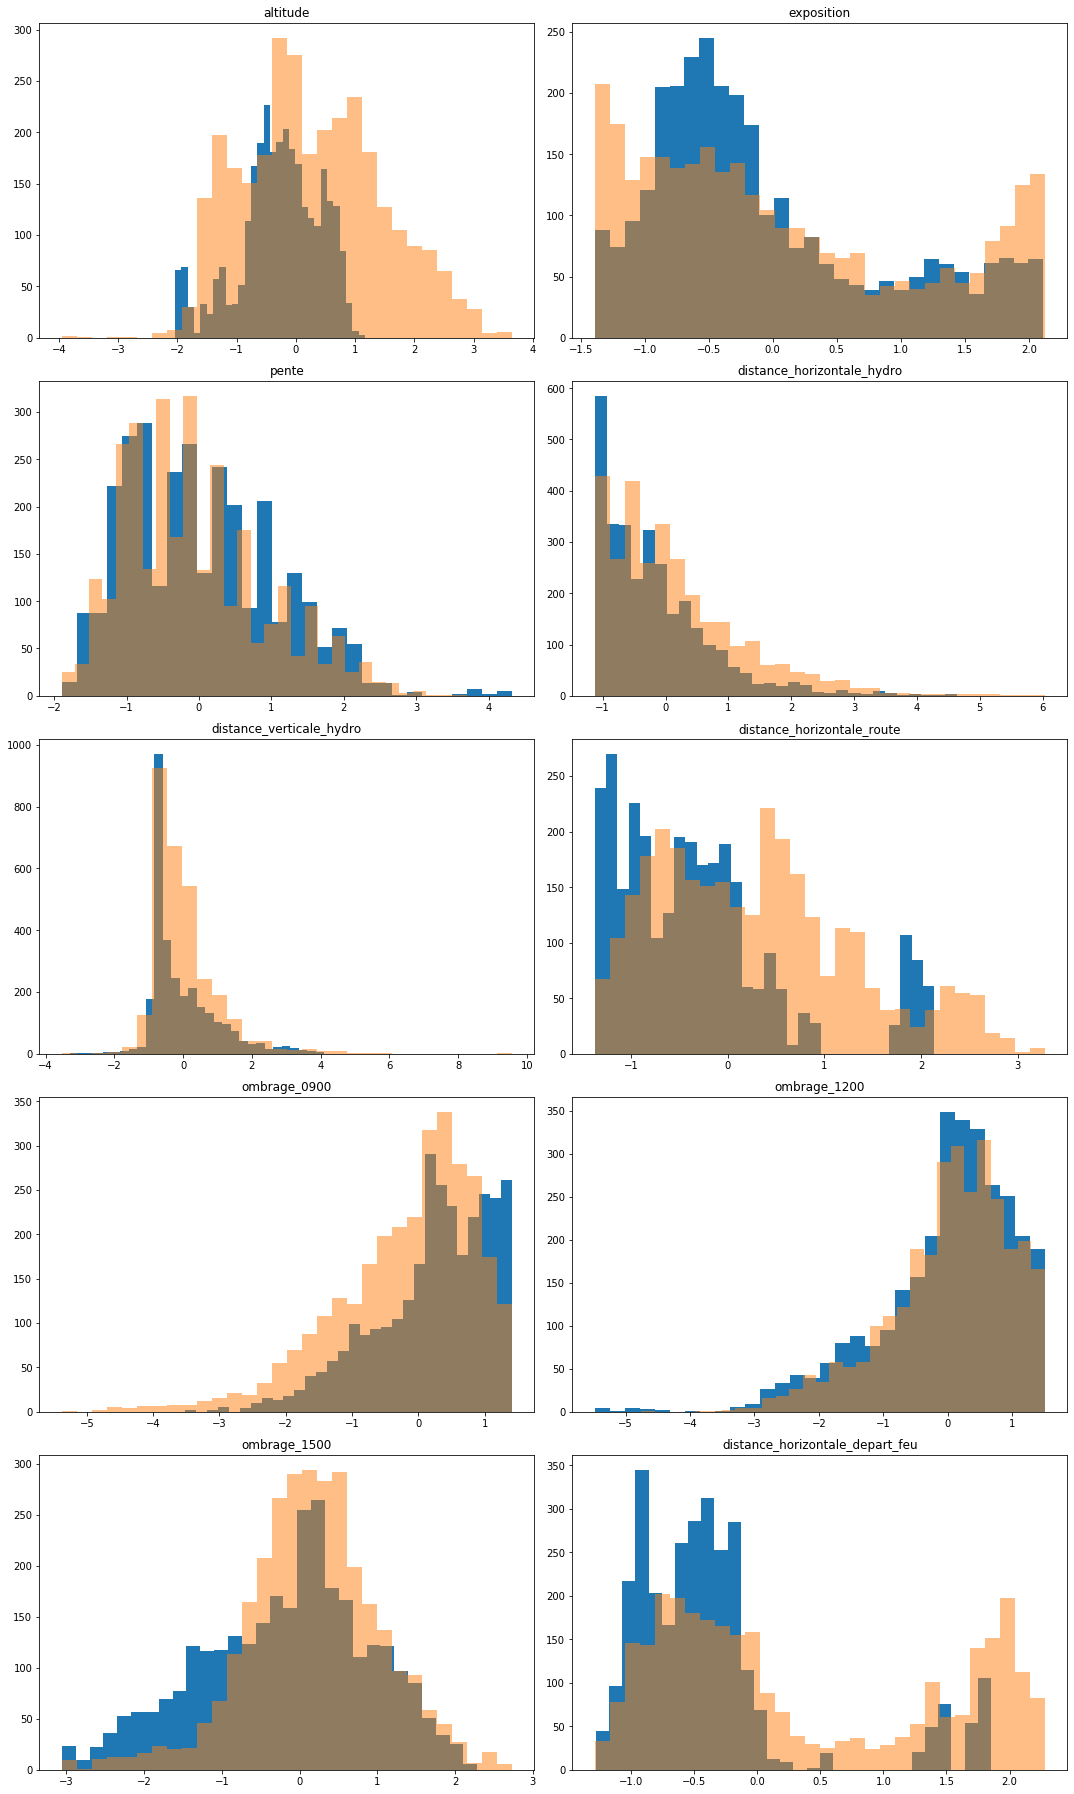

In [10]:
fig = plt.figure(figsize=(15, 25))
pos_indices = np.where(y_public == 1)[0]

neg_indices = np.where(y_public == 0)[0]

# Histograms
for (plot_idx, feat_idx) in enumerate(df_public.columns[:-1]):
    # create a subplot in the (plot_idx+1) position of a 2x5 grid
    ax = fig.add_subplot(5, 2, (plot_idx+1))
    # plot the histogram of feat_idx
    h_1 = ax.hist(X_public_preprocessed[pos_indices, plot_idx], bins=30, edgecolor='none')
    h_2 = ax.hist(X_public_preprocessed[neg_indices, plot_idx], bins=30, edgecolor='none', alpha=0.5)
    # use the name of the feature as a title for each histogram
    ax.set_title(feat_idx)
# espacement entre les subplots
fig.tight_layout(pad=1.0)

##### Minmax

In [11]:
minmax_scaler = preprocessing.MinMaxScaler()
minmax_scaler.fit(X_public)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [12]:
X_public_preprocessed_minmax = standard_scaler.transform(X_public)

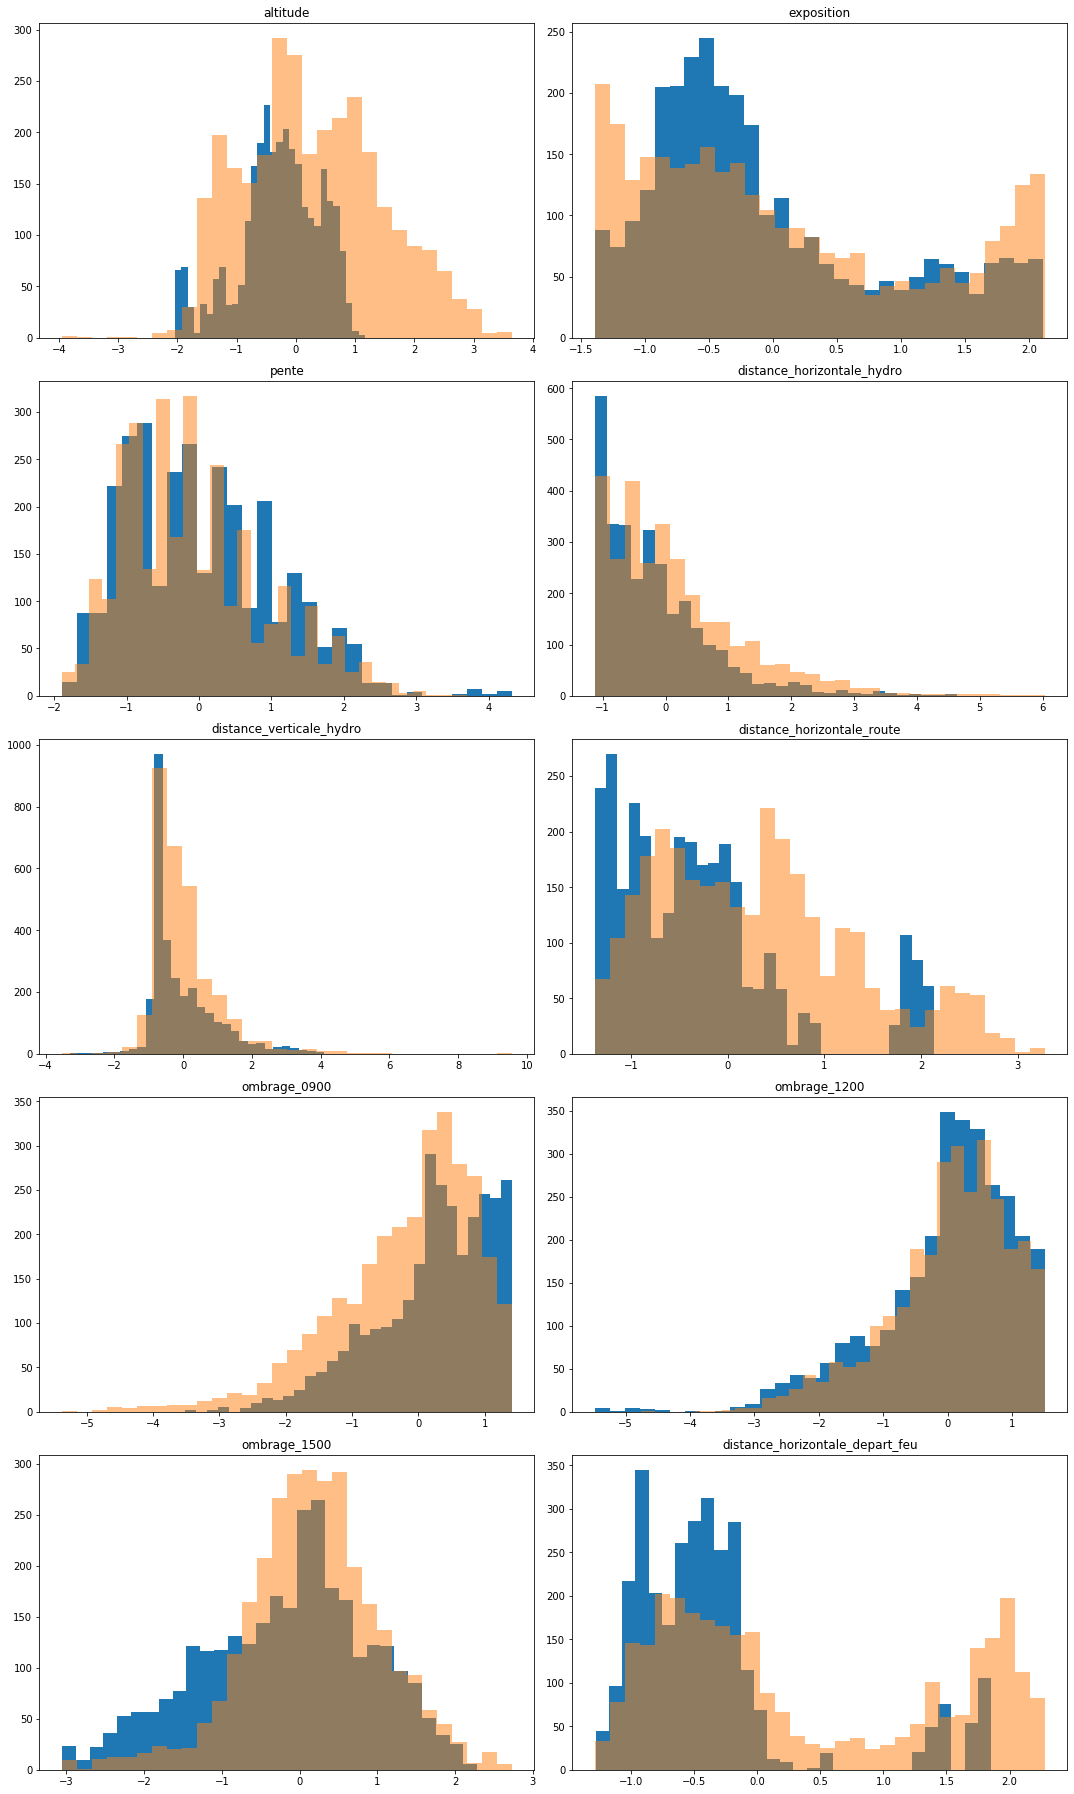

In [13]:
fig = plt.figure(figsize=(15, 25))
pos_indices = np.where(y_public == 1)[0]

neg_indices = np.where(y_public == 0)[0]

# Histograms
for (plot_idx, feat_idx) in enumerate(df_public.columns[:-1]):
    # create a subplot in the (plot_idx+1) position of a 2x5 grid
    ax = fig.add_subplot(5, 2, (plot_idx+1))
    # plot the histogram of feat_idx
    h_1 = ax.hist(X_public_preprocessed_minmax[pos_indices, plot_idx], bins=30, edgecolor='none')
    h_2 = ax.hist(X_public_preprocessed_minmax[neg_indices, plot_idx], bins=30, edgecolor='none', alpha=0.5)
    # use the name of the feature as a title for each histogram
    ax.set_title(feat_idx)
# espacement entre les subplots
fig.tight_layout(pad=1.0)

On applique un preprocessing aux données pour mettre les variables à un niveau comparable. La standardisation est testé comme méthode traditionnelle et l'algorithme MinMax car ...  
Les deux pré-traitements renvoient des résultats similaires à première vue.

## Premier modèle : 5-NN

### Algorithme des k plus proches voisins

Nous n'avons pas encore vu d'algorithme permettant d'entraîner un modèle de classification. Nous allons donc commencer avec un modèle simple : celui des __k plus proches voisins__ (ou __kNN__, pour _k nearest neighbors_).

Dans ce modèle, la valeur de la fonction de décision en x est la proportion d'individus d'étiquette positive parmi les k plus proches voisins de x au sein des points du jeu d'entraînement ; k est fixé.

Nous allons commencer par utiliser un algorithme des k plus proches voisins avec k fixé à k=5.

#### Question 4

Entraînez un modèle des sur les données `(X_public_preprocessed, y_public)` grâce à la classe `KNeighborsClassifier` du module `neighbors` de `sklearn`, utilisez l'algorithme des 5 plus proches voisins pour entrainer un modèle sur votre jeu d'entraînement.

Documentation https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

In [14]:
from sklearn import neighbors

In [15]:
neigh = neighbors.KNeighborsClassifier(n_neighbors=5)
neigh.fit(X_public_preprocessed, y_public)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [16]:
pred_public = neigh.predict(X_public_preprocessed)

In [17]:
print("Le nombre d'arbres d'espèce 1 vaut : ", pred_public.sum())

Le nombre d'arbres d'espèce 1 vaut :  3381


### Performance

Il existe de nombreuses métriques pour évaluer les performances d'un algorithme de classification. Nous allons ici utiliser le F-score, dont vous trouverez une description dans la documentation du module `metrics` de `sklearn` : https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score et https://scikit-learn.org/stable/modules/model_evaluation.html#precision-recall-f-measure-metrics.

#### Question 5
Quel serait sur nos données le F-score d'un modèle naïf prédisant systématiquement la classe positive ?

In [18]:
from sklearn import metrics

In [19]:
f1_naif = metrics.f1_score(y_public,np.ones(len(y_public)))
print("Le F-score naïf vaut : ", f1_naif)

Le F-score naïf vaut :  0.6666666666666666


#### Question 6

Quelle est le F-score du modèle de 5 plus proches voisins que vous venez d'entraîner, sur les données `(X_public_preprocessed, y_public)` ?

In [20]:
f1 = metrics.f1_score(y_public,pred_public)
print("Le F-score sur le jeu d'entraînement vaut : ", f1)

Le F-score sur le jeu d'entraînement vaut :  0.9290079924776682


#### Question 7
* Que pensez-vous de cette performance ? 
* Est-ce une bonne idée d'évaluer le modèle sur le jeu d'entraînement ? (Réfléchissez en particulier au cas où k=1.)

On obtient de bons résultats pour la méthode des plus proches voisins sur le jeu d'entraînement.  
Tester sur des données que le modèle a déjà traitées ne donne pas une vision objective de sa performance à cause du risque de surapprentissage. In fine, on ne sait pas si le modèle généralise bien.

## Création d'un jeu de test

À partir de maintenant, nous allons séparer les données en un jeu d'entraînement, que nous utiliserons pour entraîner différents modèles, et un jeu de test, que nous utiliserons pour les comparer. (Cf CM 8).

In [21]:
from sklearn import model_selection

In [22]:
# Use 20% for testing
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_public, y_public, test_size=0.20,
                                                                    stratify=y_public,
                                                                    random_state=42) 
X_train.shape, X_test.shape

((4800, 10), (1200, 10))

### Performance sur le jeu de test d'un 5-NN entraîné sur le jeu d'entrainement

#### Question 8.a 

Entrainez de nouveau un modèle avec l'algorithme des 5 plus proches voisins, mais cette fois, utilisez uniquement le jeu d'entraînement. __Attention__ à bien « entraîner » votre pre-processing sur le jeu d'entraînement seulement ; considérez le jeu de test comme des données que vous ne voyez pas au moment de l'entraînement.

In [23]:
standard_scaler = preprocessing.StandardScaler()
standard_scaler.fit(X_train) # entraînement sur le jeu d'entraînement seulement

StandardScaler(copy=True, with_mean=True, with_std=True)

In [24]:
X_train_preprocessed = standard_scaler.transform(X_train)
X_test_preprocessed = standard_scaler.transform(X_test)

In [25]:
neigh = neighbors.KNeighborsClassifier(n_neighbors=5)
neigh.fit(X_train_preprocessed, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [26]:
y_preprocessed = neigh.predict(X_test_preprocessed)

On construit les données transformées avec MinMaxScaler.  
On ne teste pas le modèle des plus proches voisins sur les données pré-traités par MinMax car le cas optimal est traité dans les questions suivantes.

In [27]:
minmax_scaler = preprocessing.MinMaxScaler()
minmax_scaler.fit(X_train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [28]:
X_train_preprocessed_minmax = minmax_scaler.transform(X_train)
X_test_preprocessed_minmax = minmax_scaler.transform(X_test)

#### Question 8.b
Évaluez le F-score sur le jeu de test du modèle entraîné à la question précédente.

In [29]:
f1_neigh = metrics.f1_score(y_test,y_preprocessed)
print("Le F-score pour 5 voisins vaut : ", f1_neigh)

Le F-score pour 5 voisins vaut :  0.8956587966488957


#### Question 9
Commentez le F-score obtenu ci-dessus.

Le F-score obtenu est satisfaisant mais sûrement améliorable en optimisant le nombre de voisins.

## [À partir du CM 8 / de la PC 4] Sélection du nombre de plus proches voisins

#### Question 10.a 
Utilisez maintenant une validation croisée pour sélectionner la valeur optimale du nombre de voisins avec `GridSearchCV` (voir notamment PC4). 

Vous pouvez utiliser la grille de valeurs de k suivante, ou la modifier :

In [30]:
from sklearn.model_selection import GridSearchCV

In [31]:
k_values = np.arange(3, 32, step=2)

In [32]:
# define model
neigh = neighbors.KNeighborsClassifier()

# define gridsearch
tuned_parameters = [{'n_neighbors': k_values}]
nb_folds = 5
grid = GridSearchCV(neigh, tuned_parameters, cv=nb_folds, refit=False, verbose=3)

# run gridsearch 
grid.fit(X_train_preprocessed, y_train)

# get R2 (default score with Lasso models)
scores = grid.cv_results_['mean_test_score']
scores_std = grid.cv_results_['std_test_score']

# compute standard errors
std_error = scores_std / np.sqrt(nb_folds)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV] n_neighbors=3 ...................................................
[CV] ....................... n_neighbors=3, score=0.890, total=   0.1s
[CV] n_neighbors=3 ...................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ....................... n_neighbors=3, score=0.894, total=   0.1s
[CV] n_neighbors=3 ...................................................
[CV] ....................... n_neighbors=3, score=0.880, total=   0.1s
[CV] n_neighbors=3 ...................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


[CV] ....................... n_neighbors=3, score=0.872, total=   0.1s
[CV] n_neighbors=3 ...................................................
[CV] ....................... n_neighbors=3, score=0.903, total=   0.1s
[CV] n_neighbors=5 ...................................................
[CV] ....................... n_neighbors=5, score=0.884, total=   0.1s
[CV] n_neighbors=5 ...................................................
[CV] ....................... n_neighbors=5, score=0.883, total=   0.1s
[CV] n_neighbors=5 ...................................................
[CV] ....................... n_neighbors=5, score=0.876, total=   0.2s
[CV] n_neighbors=5 ...................................................
[CV] ....................... n_neighbors=5, score=0.857, total=   0.2s
[CV] n_neighbors=5 ...................................................
[CV] ....................... n_neighbors=5, score=0.885, total=   0.1s
[CV] n_neighbors=7 ...................................................
[CV] .

[CV] ...................... n_neighbors=27, score=0.835, total=   0.2s
[CV] n_neighbors=27 ..................................................
[CV] ...................... n_neighbors=27, score=0.836, total=   0.2s
[CV] n_neighbors=27 ..................................................
[CV] ...................... n_neighbors=27, score=0.816, total=   0.1s
[CV] n_neighbors=27 ..................................................
[CV] ...................... n_neighbors=27, score=0.854, total=   0.2s
[CV] n_neighbors=29 ..................................................
[CV] ...................... n_neighbors=29, score=0.835, total=   0.2s
[CV] n_neighbors=29 ..................................................
[CV] ...................... n_neighbors=29, score=0.839, total=   0.2s
[CV] n_neighbors=29 ..................................................
[CV] ...................... n_neighbors=29, score=0.836, total=   0.3s
[CV] n_neighbors=29 ..................................................
[CV] .

[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:   11.9s finished


In [33]:
# get optimal k
i_max = np.argmax(scores)
best_k = k_values[i_max]
best_score = scores[i_max]
print("optimal k: {0:0.4f}".format(best_k))
print("best R2 (test set): {0:0.4f}".format(best_score))

optimal k: 3.0000
best R2 (test set): 0.8877


Le nombre optimal de voisins est 3.

#### Question 10.b
Quel est le F-score correspondant au nombre de voisin optimal ?

On calcule le F-score sur le jeu d'entraînement dans cette question. Comme dans le cas préécdent ce score n'est pas le plus significatif.

In [34]:
neigh = neighbors.KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train_preprocessed, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [35]:
y_preprocessed = neigh.predict(X_train_preprocessed)

In [36]:
f1_neigh_opt_train = metrics.f1_score(y_train,y_preprocessed)
print(f1_neigh_opt_train)

0.9437711106695809


Le F-score est amélioré par rapport à 5 voisins. (0,92 précédemment)

#### Question 10.c

Quel est le F-score, sur le jeu de test, d'un modèle obtenu en entraînant un algorithme des k plus proches voisins, avec le k que vous venez de déterminer, sur le jeu d'entraînement ? Commentez.

In [37]:
neigh = neighbors.KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train_preprocessed, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [38]:
y_preprocessed = neigh.predict(X_test_preprocessed)

In [39]:
f1_neigh_opt = metrics.f1_score(y_test,y_preprocessed)
print("Le F-score pour 3 voisins vaut :", f1_neigh_opt)

Le F-score pour 3 voisins vaut : 0.8979907264296755


Le F-score sur le jeu de test est amélioré très légèrement. Le modèle à 3 voisins généralise aussi bien que celui à  5 mais surapprend plus (F-score plus élevé sur le jeu d'entraînement).

##### MinMax

In [40]:
neigh = neighbors.KNeighborsClassifier()

# define gridsearch
tuned_parameters = [{'n_neighbors': k_values}]
nb_folds = 5
grid = GridSearchCV(neigh, tuned_parameters, cv=nb_folds, refit=False, verbose=3)

# run gridsearch 
grid.fit(X_train_preprocessed_minmax, y_train)

# get R2 (default score with Lasso models)
scores = grid.cv_results_['mean_test_score']
scores_std = grid.cv_results_['std_test_score']

# compute standard errors
std_error = scores_std / np.sqrt(nb_folds)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV] n_neighbors=3 ...................................................
[CV] ....................... n_neighbors=3, score=0.893, total=   0.1s
[CV] n_neighbors=3 ...................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ....................... n_neighbors=3, score=0.890, total=   0.1s
[CV] n_neighbors=3 ...................................................
[CV] ....................... n_neighbors=3, score=0.886, total=   0.1s
[CV] n_neighbors=3 ...................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


[CV] ....................... n_neighbors=3, score=0.880, total=   0.1s
[CV] n_neighbors=3 ...................................................
[CV] ....................... n_neighbors=3, score=0.903, total=   0.1s
[CV] n_neighbors=5 ...................................................
[CV] ....................... n_neighbors=5, score=0.879, total=   0.1s
[CV] n_neighbors=5 ...................................................
[CV] ....................... n_neighbors=5, score=0.873, total=   0.1s
[CV] n_neighbors=5 ...................................................
[CV] ....................... n_neighbors=5, score=0.881, total=   0.1s
[CV] n_neighbors=5 ...................................................
[CV] ....................... n_neighbors=5, score=0.864, total=   0.1s
[CV] n_neighbors=5 ...................................................
[CV] ....................... n_neighbors=5, score=0.898, total=   0.1s
[CV] n_neighbors=7 ...................................................
[CV] .

[CV] ...................... n_neighbors=27, score=0.830, total=   0.2s
[CV] n_neighbors=27 ..................................................
[CV] ...................... n_neighbors=27, score=0.834, total=   0.2s
[CV] n_neighbors=27 ..................................................
[CV] ...................... n_neighbors=27, score=0.828, total=   0.2s
[CV] n_neighbors=27 ..................................................
[CV] ...................... n_neighbors=27, score=0.851, total=   0.2s
[CV] n_neighbors=29 ..................................................
[CV] ...................... n_neighbors=29, score=0.833, total=   0.2s
[CV] n_neighbors=29 ..................................................
[CV] ...................... n_neighbors=29, score=0.826, total=   0.2s
[CV] n_neighbors=29 ..................................................
[CV] ...................... n_neighbors=29, score=0.835, total=   0.2s
[CV] n_neighbors=29 ..................................................
[CV] .

[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:   11.2s finished


In [41]:
# get optimal k
i_max = np.argmax(scores)
best_k = k_values[i_max]
best_score = scores[i_max]
print("optimal k: {0:0.4f}".format(best_k))
print("best R2 (test set): {0:0.4f}".format(best_score))

optimal k: 3.0000
best R2 (test set): 0.8904


Le nombre optimal de voisins est ainsi le même pour les deux pré-traitements.

In [42]:
neigh = neighbors.KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train_preprocessed_minmax, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [43]:
y_preprocessed = neigh.predict(X_test_preprocessed_minmax)

In [44]:
f1_neigh_opt_minmax = metrics.f1_score(y_test,y_preprocessed)
print("Le F-score pour 3 voisins et MinMax vaut :", f1_neigh_opt_minmax)

Le F-score pour 3 voisins et MinMax vaut : 0.9061287820015514


Le F-score est amélioré par rapport à celui obtenu avec la standardisation.

## [À partir de la PC 5] Régression logistique

### Régression logistique non-régularisée

#### Question 11.a

Entraînez une régression logistique non-régularisée sur le jeu d'entraînement.

__Conseils :__
* Vous trouverez les outils nécessaires dans la classe `LogisticRegression` du module `linear_model` de `scikit-learn` ; il s'agit ainsi d'une variante de la PC5. Comme toujours, référez-vous à la [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).
* Pour ne pas avoir de régularisation, utilisez `penalty='none'`

In [45]:
from sklearn.linear_model import LogisticRegression

In [46]:
logreg = LogisticRegression(penalty='none') # pas de pénalité
logreg.fit(X_train_preprocessed, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [47]:
y_preprocessed = logreg.predict(X_test_preprocessed)

#### Question 11.b
Évaluez le F-score de cette régression logistique non-régularisée sur le jeu de test.

In [48]:
f1_logreg_no_penalty = metrics.f1_score(y_test,y_preprocessed)
print("Le F-score pour la régression logistique sans pénalité vaut : ", f1_logreg_no_penalty)

Le F-score pour la régression logistique sans pénalité vaut :  0.7756778964667215


#### Question 12
Vous attendez-vous à ce qu'utiliser une régularisation l2 améliore les performances du modèle ? Pourquoi ?

Une régularisation l2 diminue le surapprentissage. Une amélioration des performances est donc attendue. 

Nous pouvons le vérifier

In [49]:
logreg = LogisticRegression(penalty='l2', C=1e-2) # régularisation ridge
logreg.fit(X_train_preprocessed, y_train)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [50]:
y_preprocessed = logreg.predict(X_test_preprocessed)

In [51]:
f1_logreg_l2 = metrics.f1_score(y_test,y_preprocessed)
print("Le F-score pour la régression logistique avec pénalité l2 vaut : ", f1_logreg_l2)

Le F-score pour la régression logistique avec pénalité l2 vaut :  0.778512396694215


Le F-score est bien légèrement amélioré mais la différence n'est pas réellement significative.

#### Question 13.a
Déterminez par validation croisée une valeur optimale du coefficient de régularisation d'une régression logistique avec régularisation ridge.

In [52]:
C_values = np.logspace(-3, 0, 30)

In [53]:
# define model
logreg = LogisticRegression(penalty='l1', random_state=13, max_iter=10000, solver='saga') # régularisation lasso

# define gridsearch
tuned_parameters = [{'C': C_values}]
nb_folds = 5
grid = GridSearchCV(logreg, tuned_parameters, cv=nb_folds, refit=False, verbose=3)

# run gridsearch 
grid.fit(X_train_preprocessed, y_train)

# get R2 (default score with Lasso models)
scores = grid.cv_results_['mean_test_score']
scores_std = grid.cv_results_['std_test_score']

# compute standard errors
std_error = scores_std / np.sqrt(nb_folds)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] C=0.001 .........................................................
[CV] ............................. C=0.001, score=0.500, total=   0.0s
[CV] C=0.001 .........................................................
[CV] ............................. C=0.001, score=0.500, total=   0.0s
[CV] C=0.001 .........................................................
[CV] ............................. C=0.001, score=0.500, total=   0.0s
[CV] C=0.001 .........................................................
[CV] ............................. C=0.001, score=0.500, total=   0.0s
[CV] C=0.001 .........................................................
[CV] ............................. C=0.001, score=0.500, total=   0.0s
[CV] C=0.0012689610031679222 .........................................
[CV] ............. C=0.0012689610031679222, score=0.500, total=   0.0s
[CV] C=0.0012689610031679222 .........................................
[CV] ..........

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV] C=0.0016102620275609393 .........................................
[CV] ............. C=0.0016102620275609393, score=0.665, total=   0.0s
[CV] C=0.0016102620275609393 .........................................
[CV] ............. C=0.0016102620275609393, score=0.688, total=   0.0s
[CV] C=0.0016102620275609393 .........................................
[CV] ............. C=0.0016102620275609393, score=0.685, total=   0.0s
[CV] C=0.0016102620275609393 .........................................
[CV] ............. C=0.0016102620275609393, score=0.653, total=   0.0s
[CV] C=0.0016102620275609393 .........................................
[CV] ............. C=0.0016102620275609393, score=0.649, total=   0.0s
[CV] C=0.0020433597178569417 .........................................
[CV] ............. C=0.0020433597178569417, score=0.760, total=   0.0s
[CV] C=0.0020433597178569417 .........................................
[CV] ............. C=0.0020433597178569417, score=0.758, total=   0.0s
[CV] 

[CV] ............... C=0.02807216203941177, score=0.776, total=   0.0s
[CV] C=0.02807216203941177 ...........................................
[CV] ............... C=0.02807216203941177, score=0.767, total=   0.1s
[CV] C=0.02807216203941177 ...........................................
[CV] ............... C=0.02807216203941177, score=0.778, total=   0.1s
[CV] C=0.02807216203941177 ...........................................
[CV] ............... C=0.02807216203941177, score=0.760, total=   0.1s
[CV] C=0.02807216203941177 ...........................................
[CV] ............... C=0.02807216203941177, score=0.776, total=   0.1s
[CV] C=0.035622478902624426 ..........................................
[CV] .............. C=0.035622478902624426, score=0.776, total=   0.1s
[CV] C=0.035622478902624426 ..........................................
[CV] .............. C=0.035622478902624426, score=0.769, total=   0.1s
[CV] C=0.035622478902624426 ..........................................
[CV] .

[CV] ............... C=0.38566204211634725, score=0.752, total=   0.3s
[CV] C=0.38566204211634725 ...........................................
[CV] ............... C=0.38566204211634725, score=0.773, total=   0.2s
[CV] C=0.4893900918477494 ............................................
[CV] ................ C=0.4893900918477494, score=0.770, total=   0.2s
[CV] C=0.4893900918477494 ............................................
[CV] ................ C=0.4893900918477494, score=0.775, total=   0.4s
[CV] C=0.4893900918477494 ............................................
[CV] ................ C=0.4893900918477494, score=0.774, total=   0.4s
[CV] C=0.4893900918477494 ............................................
[CV] ................ C=0.4893900918477494, score=0.751, total=   0.4s
[CV] C=0.4893900918477494 ............................................
[CV] ................ C=0.4893900918477494, score=0.775, total=   0.3s
[CV] C=0.6210169418915616 ............................................
[CV] .

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   12.7s finished


In [54]:
# get optimal C
i_max = np.argmax(scores)
best_C = C_values[i_max]
best_score = scores[i_max]
print("optimal C: {0:0.4f}".format(best_C))
print("best R2 (test set): {0:0.4f}".format(best_score))

optimal C: 0.0042
best R2 (test set): 0.7769


#### Question 13.b
Quel est le F-score, sur le jeu de test, d'une régression logistique avec régularisation ridge et ce coefficient de régularisation optimal, entraînée sur le jeu d'entraînement ?

In [55]:
logreg = LogisticRegression(penalty='l2', C=0.0042)
logreg.fit(X_train_preprocessed, y_train)

LogisticRegression(C=0.0042, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [56]:
y_preprocessed = logreg.predict(X_test_preprocessed)

In [57]:
f1_logreg_opt = metrics.f1_score(y_test,y_preprocessed)
print("Le F-score pour la régression logistique avec régularisation l1 vaut : ", f1_logreg_opt)

Le F-score pour la régression logistique avec régularisation l1 vaut :  0.7725392886683208


#### Question 13.c
Commentez ce résultat en regard de votre réponse à la question 12.

Le F1-score n'est pas amélioré par rapport à une régularisation l2. Cela peut signifier que toutes les variables ont un poids un minimum significatif dans la prévision de l'étiquette, en opposition à une régularisation lasso qui pénalise des petits coeficients non nuls.

##### Minmax

In [58]:
# define model
logreg = LogisticRegression(penalty='l1', random_state=13, max_iter=10000, solver='saga')

# define gridsearch
tuned_parameters = [{'C': C_values}]
nb_folds = 5
grid = GridSearchCV(logreg, tuned_parameters, cv=nb_folds, refit=False, verbose=3)

# run gridsearch 
grid.fit(X_train_preprocessed_minmax, y_train)

# get R2 (default score with Lasso models)
scores = grid.cv_results_['mean_test_score']
scores_std = grid.cv_results_['std_test_score']

# compute standard errors
std_error = scores_std / np.sqrt(nb_folds)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] C=0.001 .........................................................
[CV] ............................. C=0.001, score=0.500, total=   0.0s
[CV] C=0.001 .........................................................
[CV] ............................. C=0.001, score=0.500, total=   0.0s
[CV] C=0.001 .........................................................
[CV] ............................. C=0.001, score=0.500, total=   0.0s
[CV] C=0.001 .........................................................
[CV] ............................. C=0.001, score=0.500, total=   0.0s
[CV] C=0.001 .........................................................
[CV] ............................. C=0.001, score=0.500, total=   0.0s
[CV] C=0.0012689610031679222 .........................................
[CV] ............. C=0.0012689610031679222, score=0.500, total=   0.0s
[CV] C=0.0012689610031679222 .........................................
[CV] ..........

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s



[CV] C=0.0020433597178569417 .........................................
[CV] ............. C=0.0020433597178569417, score=0.500, total=   0.0s
[CV] C=0.0020433597178569417 .........................................
[CV] ............. C=0.0020433597178569417, score=0.500, total=   0.0s
[CV] C=0.0020433597178569417 .........................................
[CV] ............. C=0.0020433597178569417, score=0.500, total=   0.0s
[CV] C=0.0020433597178569417 .........................................
[CV] ............. C=0.0020433597178569417, score=0.500, total=   0.0s
[CV] C=0.0020433597178569417 .........................................
[CV] ............. C=0.0020433597178569417, score=0.500, total=   0.0s
[CV] C=0.002592943797404667 ..........................................
[CV] .............. C=0.002592943797404667, score=0.500, total=   0.0s
[CV] C=0.002592943797404667 ..........................................
[CV] .............. C=0.002592943797404667, score=0.500, total=   0.0s
[CV] 

[CV] ............... C=0.02807216203941177, score=0.754, total=   0.0s
[CV] C=0.035622478902624426 ..........................................
[CV] .............. C=0.035622478902624426, score=0.778, total=   0.0s
[CV] C=0.035622478902624426 ..........................................
[CV] .............. C=0.035622478902624426, score=0.761, total=   0.0s
[CV] C=0.035622478902624426 ..........................................
[CV] .............. C=0.035622478902624426, score=0.785, total=   0.0s
[CV] C=0.035622478902624426 ..........................................
[CV] .............. C=0.035622478902624426, score=0.752, total=   0.1s
[CV] C=0.035622478902624426 ..........................................
[CV] .............. C=0.035622478902624426, score=0.769, total=   0.1s
[CV] C=0.04520353656360243 ...........................................
[CV] ............... C=0.04520353656360243, score=0.785, total=   0.0s
[CV] C=0.04520353656360243 ...........................................
[CV] .

[CV] ................ C=0.4893900918477494, score=0.779, total=   0.0s
[CV] C=0.4893900918477494 ............................................
[CV] ................ C=0.4893900918477494, score=0.761, total=   0.0s
[CV] C=0.4893900918477494 ............................................
[CV] ................ C=0.4893900918477494, score=0.777, total=   0.0s
[CV] C=0.6210169418915616 ............................................
[CV] ................ C=0.6210169418915616, score=0.775, total=   0.1s
[CV] C=0.6210169418915616 ............................................
[CV] ................ C=0.6210169418915616, score=0.767, total=   0.0s
[CV] C=0.6210169418915616 ............................................
[CV] ................ C=0.6210169418915616, score=0.779, total=   0.1s
[CV] C=0.6210169418915616 ............................................
[CV] ................ C=0.6210169418915616, score=0.760, total=   0.1s
[CV] C=0.6210169418915616 ............................................
[CV] .

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    6.4s finished


In [59]:
# get optimal C
i_max = np.argmax(scores)
best_C = C_values[i_max]
best_score = scores[i_max]
print("optimal C: {0:0.4f}".format(best_C))
print("best R2 (test set): {0:0.4f}".format(best_score))

optimal C: 0.0728
best R2 (test set): 0.7740


In [60]:
logreg = LogisticRegression(penalty='l1', C=0.0728, solver='saga')
logreg.fit(X_train_preprocessed_minmax, y_train)

LogisticRegression(C=0.0728, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [61]:
y_preprocessed = logreg.predict(X_test_preprocessed_minmax)

In [62]:
f1_logreg_opt_minmax = metrics.f1_score(y_test,y_preprocessed)
print("Le F-score pour MinMax et la régression logistique avec régularisation l1 vaut : ", f1_logreg_opt_minmax)

Le F-score pour MinMax et la régression logistique avec régularisation l1 vaut :  0.7745098039215687


#### Question 14

Entraînez une forêt aléatoire sur le jeu d'entraînement et évaluez son F-score sur le jeu de test.

__Conseils :__
* Vous trouverez les outils nécessaires dans la classe `RandomForestClassifier` du module `ensemble` de `scikit-learn`.
* Choisissez le nombre d'arbres par validation croisée.

In [63]:
from sklearn.ensemble import RandomForestClassifier

In [64]:
n_values = np.arange(10, 100, 10)
n_values

array([10, 20, 30, 40, 50, 60, 70, 80, 90])

In [65]:
# define model
forest = RandomForestClassifier(random_state=13)

# define gridsearch
tuned_parameters = [{'n_estimators': n_values}]
nb_folds = 5
grid = GridSearchCV(forest, tuned_parameters, cv=nb_folds, refit=False, verbose=3)

# run gridsearch 
grid.fit(X_train_preprocessed, y_train)

# get R2 (default score with Lasso models)
scores = grid.cv_results_['mean_test_score']
scores_std = grid.cv_results_['std_test_score']

# compute standard errors
std_error = scores_std / np.sqrt(nb_folds)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] n_estimators=10 .................................................
[CV] ..................... n_estimators=10, score=0.917, total=   0.2s
[CV] n_estimators=10 .................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] ..................... n_estimators=10, score=0.923, total=   0.2s
[CV] n_estimators=10 .................................................
[CV] ..................... n_estimators=10, score=0.914, total=   0.1s
[CV] n_estimators=10 .................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


[CV] ..................... n_estimators=10, score=0.902, total=   0.2s
[CV] n_estimators=10 .................................................
[CV] ..................... n_estimators=10, score=0.912, total=   0.2s
[CV] n_estimators=20 .................................................
[CV] ..................... n_estimators=20, score=0.927, total=   0.3s
[CV] n_estimators=20 .................................................
[CV] ..................... n_estimators=20, score=0.927, total=   0.3s
[CV] n_estimators=20 .................................................
[CV] ..................... n_estimators=20, score=0.923, total=   0.3s
[CV] n_estimators=20 .................................................
[CV] ..................... n_estimators=20, score=0.919, total=   0.3s
[CV] n_estimators=20 .................................................
[CV] ..................... n_estimators=20, score=0.926, total=   0.3s
[CV] n_estimators=30 .................................................
[CV] .

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:   35.2s finished


In [66]:
# get optimal n
i_max = np.argmax(scores)
best_n = n_values[i_max]
best_score = scores[i_max]
print("optimal n: {0:0.4f}".format(best_n))
print("best R2 (test set): {0:0.4f}".format(best_score))

optimal n: 70.0000
best R2 (test set): 0.9306


In [67]:
forest = RandomForestClassifier(n_estimators=70)
forest.fit(X_train_preprocessed, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=70,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [68]:
y_preprocessed = forest.predict(X_test_preprocessed)

In [69]:
f1_forest_opt = metrics.f1_score(y_test,y_preprocessed)
print("Le F-score pour une forêt aléatoire vaut :", f1_forest_opt)

Le F-score pour une forêt aléatoire vaut : 0.945748987854251


##### Minmax

In [70]:
# define model
forest = RandomForestClassifier(random_state=13)

# define gridsearch
tuned_parameters = [{'n_estimators': n_values}]
nb_folds = 5
grid = GridSearchCV(forest, tuned_parameters, cv=nb_folds, refit=False, verbose=3)

# run gridsearch 
grid.fit(X_train_preprocessed_minmax, y_train)

# get R2 (default score with Lasso models)
scores = grid.cv_results_['mean_test_score']
scores_std = grid.cv_results_['std_test_score']

# compute standard errors
std_error = scores_std / np.sqrt(nb_folds)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] n_estimators=10 .................................................
[CV] ..................... n_estimators=10, score=0.916, total=   0.2s
[CV] n_estimators=10 .................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] ..................... n_estimators=10, score=0.922, total=   0.2s
[CV] n_estimators=10 .................................................
[CV] ..................... n_estimators=10, score=0.917, total=   0.2s
[CV] n_estimators=10 .................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s


[CV] ..................... n_estimators=10, score=0.904, total=   0.2s
[CV] n_estimators=10 .................................................
[CV] ..................... n_estimators=10, score=0.916, total=   0.2s
[CV] n_estimators=20 .................................................
[CV] ..................... n_estimators=20, score=0.927, total=   0.3s
[CV] n_estimators=20 .................................................
[CV] ..................... n_estimators=20, score=0.925, total=   0.3s
[CV] n_estimators=20 .................................................
[CV] ..................... n_estimators=20, score=0.924, total=   0.3s
[CV] n_estimators=20 .................................................
[CV] ..................... n_estimators=20, score=0.920, total=   0.3s
[CV] n_estimators=20 .................................................
[CV] ..................... n_estimators=20, score=0.928, total=   0.3s
[CV] n_estimators=30 .................................................
[CV] .

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:   35.5s finished


In [71]:
# get optimal n
i_max = np.argmax(scores)
best_n = n_values[i_max]
best_score = scores[i_max]
print("optimal n: {0:0.4f}".format(best_n))
print("best R2 (test set): {0:0.4f}".format(best_score))

optimal n: 50.0000
best R2 (test set): 0.9300


In [72]:
forest_minmax = RandomForestClassifier(n_estimators=50)
forest_minmax.fit(X_train_preprocessed_minmax, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [73]:
y_preprocessed = forest_minmax.predict(X_test_preprocessed_minmax)

In [74]:
f1_forest_opt_minmax = metrics.f1_score(y_test,y_preprocessed)
print("Le F-score pour MinMax et une forêt aléatoire vaut :", f1_forest_opt_minmax)

Le F-score pour MinMax et une forêt aléatoire vaut : 0.9390739236393176


## Modèle final

#### Question 15.a
Visualisez les performances des différents modèles (et pré-traitements) que vous avez évalués sur le jeu de test.

Text(0, 0.5, 'F-scores')

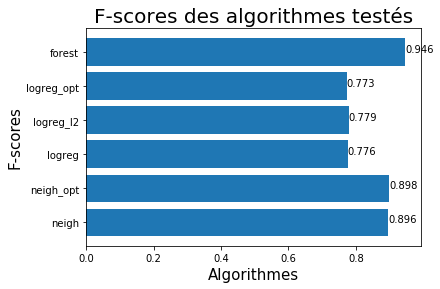

In [75]:
f1s = [f1_neigh, f1_neigh_opt, f1_logreg_no_penalty, f1_logreg_l2, f1_logreg_opt, f1_forest_opt]
f1s_labels = ['neigh', 'neigh_opt', 'logreg', 'logreg_l2', 'logreg_opt', 'forest']

plt.barh(np.arange(len(f1s)), f1s, tick_label=f1s_labels)
  
for index, value in enumerate(f1s):
    plt.text(value, index, str("%.3f" % value))
    
plt.xlabel("Algorithmes", fontsize=15)
plt.title("F-scores des algorithmes testés", fontsize=20)
plt.ylabel("F-scores", fontsize=15)

In [76]:
print("L'algorithme avec le meilleur F-score est ", f1s_labels[np.argmax(f1s)])
print("De F-score", np.max(f1s))

L'algorithme avec le meilleur F-score est  forest
De F-score 0.945748987854251


##### Minmax

Text(0, 0.5, 'F-scores')

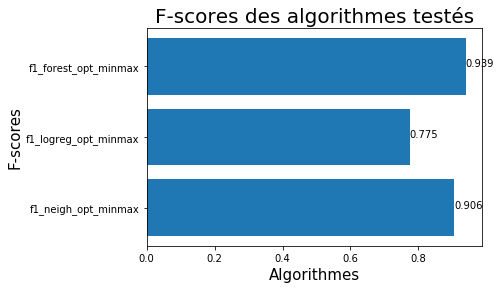

In [77]:
f1s = [f1_neigh_opt_minmax, f1_logreg_opt_minmax, f1_forest_opt_minmax]
f1s_labels = ['f1_neigh_opt_minmax', 'f1_logreg_opt_minmax', 'f1_forest_opt_minmax']

plt.barh(np.arange(len(f1s)), f1s, tick_label=f1s_labels)
  
for index, value in enumerate(f1s):
    plt.text(value, index, str("%.3f" % value))
    
plt.xlabel("Algorithmes", fontsize=15)
plt.title("F-scores des algorithmes testés", fontsize=20)
plt.ylabel("F-scores", fontsize=15)

In [78]:
print("L'algorithme avec le meilleur F-score est ", f1s_labels[np.argmax(f1s)])
print("De F-score", np.max(f1s))

L'algorithme avec le meilleur F-score est  f1_forest_opt_minmax
De F-score 0.9390739236393176


Les résultats obtenus par la fôret aléatoire sont les meilleurs et quasi égaux pour les deux preprocessing.

Au final, la comparaison des F1-scores nous conduit à choisir les paramètres suivants:
- La standardisation MinMax
- L'algorithme Forest avec 50 arbres

#### En utilisant les courbes ROC

In [79]:
from sklearn.metrics import roc_auc_score, plot_roc_curve

Score ROC : 0.9365166666666667


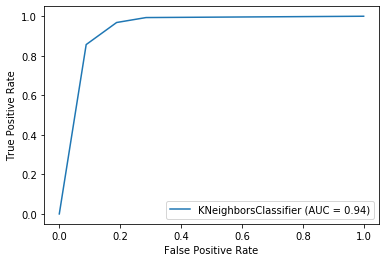

In [80]:
neigh = neighbors.KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train_preprocessed, y_train)
y_preprocessed = neigh.predict_proba(X_test_preprocessed)
print(f"Score ROC : {roc_auc_score(y_test, y_preprocessed[:, 1])}")
plot_roc_curve(neigh, X_test_preprocessed, y_test);

Score ROC : 0.8254833333333332


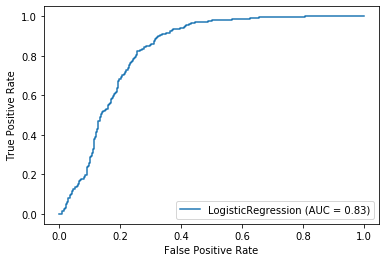

In [81]:
logreg = LogisticRegression(penalty='l1', C=0.0042, solver='saga')
logreg.fit(X_train_preprocessed, y_train)
y_preprocessed = logreg.predict_proba(X_test_preprocessed)
print(f"Score ROC : {roc_auc_score(y_test, y_preprocessed[:, 1])}")
plot_roc_curve(logreg, X_test_preprocessed, y_test);

Score ROC : 0.9841555555555556


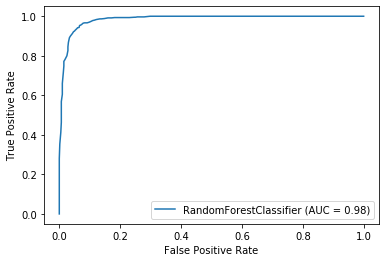

In [82]:
forest = RandomForestClassifier(n_estimators=70)
forest.fit(X_train_preprocessed, y_train)
y_preprocessed = forest.predict_proba(X_test_preprocessed)
print(f"Score ROC : {roc_auc_score(y_test, y_preprocessed[:, 1])}")
plot_roc_curve(forest, X_test_preprocessed, y_test);

##### MinMax

Score ROC : 0.9396152777777778


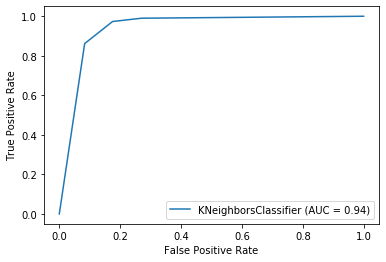

In [83]:
neigh_minmax = neighbors.KNeighborsClassifier(n_neighbors=3)
neigh_minmax.fit(X_train_preprocessed_minmax, y_train)
y_preprocessed = neigh_minmax.predict_proba(X_test_preprocessed_minmax)
print(f"Score ROC : {roc_auc_score(y_test, y_preprocessed[:, 1])}")
plot_roc_curve(neigh_minmax, X_test_preprocessed_minmax, y_test);

Score ROC : 0.8309277777777779


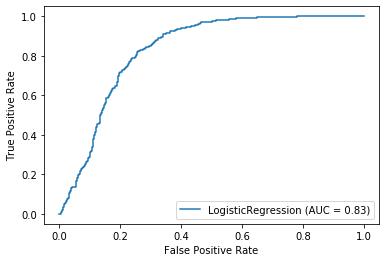

In [84]:
logreg_minmax = LogisticRegression(penalty='l1', C=0.0728, solver='saga')
logreg_minmax.fit(X_train_preprocessed_minmax, y_train)
y_preprocessed = logreg_minmax.predict_proba(X_test_preprocessed_minmax)
print(f"Score ROC : {roc_auc_score(y_test, y_preprocessed[:, 1])}")
plot_roc_curve(logreg_minmax, X_test_preprocessed_minmax, y_test);

Score ROC : 0.9849277777777778


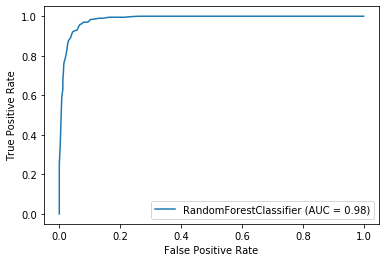

In [85]:
forest_minmax = RandomForestClassifier(n_estimators=50)
forest_minmax.fit(X_train_preprocessed_minmax, y_train)
y_preprocessed = forest_minmax.predict_proba(X_test_preprocessed_minmax)
print(f"Score ROC : {roc_auc_score(y_test, y_preprocessed[:, 1])}")
plot_roc_curve(forest_minmax, X_test_preprocessed_minmax, y_test);

L'analyse des courbes ROC et du score AUC (aire sous la courbe ROC qui l'on cherche à maximiser) nous conduit à choisir le même modèle que l'étude des F1-scores, c'est-à-dire:
- La standardisation MinMax
- L'algorithme Forest avec 50 arbres

#### Question 15.b
Utilisez cette figure pour __sélectionner votre modèle favori__. Quel pré-traitement choisissez-vous ? Quel algorithme choisissez-vous, avec quel hyper-paramètre ? 

Voir les remarques précédentes.  
Le modèle choisi est:
- Standardisation avec l'algorithme MinMax
- Prédiction avec l'algorithme Forest (50 arbres)

#### Question 16.a
Chargez les données privées de `data/foret_prive.tsv` pour obtenir un array `X_private`. Le fichier suit la même syntaxe que `data/foret_public.tsv`, mais sans la colonne des étiquettes.

In [86]:
df_private = pd.read_csv('data/foret_prive.tsv', delimiter='\t')

In [87]:
df_private.head()

,altitude,exposition,pente,distance_horizontale_hydro,distance_verticale_hydro,distance_horizontale_route,ombrage_0900,ombrage_1200,ombrage_1500,distance_horizontale_depart_feu
0,2654,42,15,60,7,1862,221,206,116,6907
1,2649,24,13,30,2,1832,213,211,133,6889
2,2647,357,16,0,0,1802,194,210,152,6870
3,2650,5,19,0,0,1772,192,199,141,6852
4,2645,25,24,30,7,1742,201,182,108,6834


In [88]:
X_private = np.array(df_private)

#### Question 16.b
Appliquez le pré-traitement que vous avez choisi à l'intégralité du jeu de données public `X_public` pour obtenir `X_public_preprocessed`.

In [89]:
minmax_scaler = preprocessing.MinMaxScaler()
minmax_scaler.fit(X_public)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [90]:
X_public_preprocessed = minmax_scaler.transform(X_public)

#### Question 16.c
Appliquez à `X_private` le pré-traitement que vous avez choisi ; enregistrez le résultat dans `X_private_preprocessed`.

In [91]:
X_private_preprocessed = minmax_scaler.transform(X_private)

#### Question 16.d
Entraînez l'algorithme que vous avez sélectionné sur l'intégralité des données publiques `(X_public_processed, y_public)`. 

In [92]:
forest = RandomForestClassifier(n_estimators=50)
forest.fit(X_public_preprocessed, y_public)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

#### Question 16.e
Prédisez les étiquettes de `X_private_preprocessed` ; enregistrez le résultat dans un array `y_pred_final`

In [93]:
y_pred_final = forest.predict(X_private_preprocessed)

#### Question 16.f
Utilisez le code suivant pour créer le fichier de prédictions que vous rendrez. 

__Attention__ Si vous ouvrez ce fichier avec un programme externe type Microsoft Excel ou LibreOffice Calc pour le lire, il est possible que ce programme modifie le fichier sans que vous ne le réalisiez. Préférez utiliser une commande bash type `less` ou `cat` ou éditeur de texte simple ; ou alors assurez-vous de relancer la commande.

In [94]:
# Save array to file
np.savetxt("test_file.tsv", 
           y_pred_final,
           fmt=('%d'), 
           header='Prediction',
           delimiter='\t', comments="")

## Bonus

1. En alternative au F-score, utilisez des courbes ROC (et l'aire sous ces courbes) pour comparer vos modèles. Attention à utiliser les méthodes `predict_proba()` plutôt que `predict()` pour obtenir des scores non-seuillés plutôt que des prédictions binaires. Documentation pertinente : https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_roc_curve.html et  https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html.

1. Explorez d'autres pré-traitements (comme par exemple le fait de réduire la dimension des données) et d'autres algorithmes d'apprentissage implémentés dans scikit-learn (par exemple SVM, perceptrons multi-couches) pour essayer d'améliorer vos prédictions et reprenez la question 15.